# Neural network, no tears

Let's make our own neural network (NN)! This NN will have 1 input layer, 1 hidden layer, and 1 output layer. Each of these layers will have 2 nodes. The purpose of this NN will be to classify data points coming from two different distributions. This problem is the classic binary classification problem.

# Sample (synthetic) data

There will be 2 classes of data points. For this purpose, we will sample data points from 2 different multivariate distributions as follows.

* $y_1 \sim \mathcal{N}(\mu_1, \Sigma_1)$
* $y_2 \sim \mathcal{N}(\mu_2, \Sigma_2)$

where

* $\mu_1 = [0, 0]$
* $\mu_2 = [5, 5]$
* $\Sigma_1 =
\begin{bmatrix}
1 & 2\\
2 & 1
\end{bmatrix}$
* $\Sigma_2 =
\begin{bmatrix}
1 & 1\\
2 & 1
\end{bmatrix}$

If we sample from $y_1$ then all labels will be 0, and if we sample from $y_2$ then all labels will be 1.

In [1]:
import numpy as np
from scipy.stats import multivariate_normal

n = 1000
np.random.seed(104729)

m_1 = np.array([0.0, 0.0], dtype=np.float)
m_2 = np.array([5.0, 5.0], dtype=np.float)

cov_1 = np.array([
    [1.0, 2.0], 
    [2.0, 1.0]], 
    dtype=np.float)
cov_2 = np.array([
    [1.0, 2.0], 
    [2.0, 1.0]], 
    dtype=np.float)

X1 = multivariate_normal.rvs(mean=m_1, cov=cov_1, size=n/2)
X2 = multivariate_normal.rvs(mean=m_2, cov=cov_2, size=n/2)
y_1 = np.zeros(n/2).reshape(n/2, 1)
y_2 = np.ones(n/2).reshape(n/2, 1)

X = np.vstack([X1, X2])
y = np.vstack([y_1, y_2])

print('X shape is {}'.format(X.shape))
print('y shape is {}'.format(y.shape))

X shape is (1000, 2)
y shape is (1000, 1)


/anaconda3/envs/ds/lib/python2.7/site-packages/scipy/stats/_multivariate.py:651: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


Now, let's plot our sample points. Red dots are our positive examples (our 1's), and green dots are our negative examples (our 0's). Clearly, our positive examples center around $[5, 5]$ and our negative examples center around $[0, 0]$ as we sampled our examples from the multivariate Gaussian at these means.

Text(0,0.5,'$x_1$')

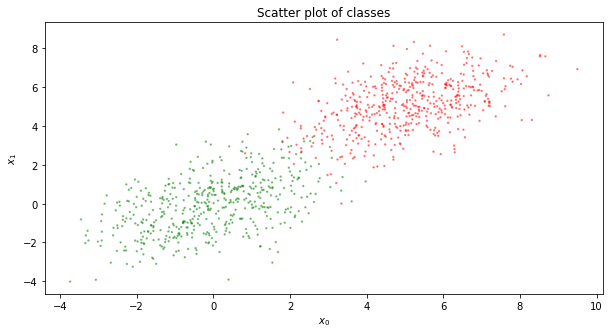

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=False, sharey=False)

colors = ['r' if 1 == v else 'g' for v in y]
ax.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.4, s=2)
ax.set_title('Scatter plot of classes')
ax.set_xlabel(r'$x_0$')
ax.set_ylabel(r'$x_1$')

# Neural network architecture

Again, our NN has 3 layers, each layer having 2 nodes, and they are defined as follows.

* Layer 1: input layer
* Layer 2: hidden layer
* Layer 3: output layer

These layers are fully connected, meaning, all nodes in the current layer connect to all other nodes in the next layer. For the 

* input to hidden layer, since there are 2 nodes in each of these layers, there is a total of $2 \times 2 = 4$ connections, and
* hidden to output layer, since there are 2 nodes in each of these layers also, there is a total of $2 \times 2 = 4$ connections.

The way practioners represent these inter-layer connections is through matrices. There will always be $K - 1$ matrices to represent a NN, where $K$ is the number of layers. In our example, we will have a matrix that looks like the following.

$
W_{ih} = \begin{bmatrix}
w_{11} && w_{21}\\
w_{12} && w_{22}
\end{bmatrix}
$

where

* $W_{ih}$ is the connection matrix between the input to hidden layer, and
* $w_{jk}$ in the connection matrix is the `weight` of the connection from the `j-th` input node to the `k-th` hidden node.

For clarity, here are the weights defined.

* $w_{11}$ is the weight of the connection from the `first` input node to the `first` hidden node,
* $w_{12}$ is the weight of the connection from the `first` input node to the `second` hidden node,
* $w_{21}$ is the weight of the connection from the `first` input node to the `first` hidden node,
* $w_{22}$ is the weight of the connection from the `first` input node to the `first` hidden node

While we are defining connection (or weight) matrices, the connection matrix to represent the hidden to output layer is denoted as follows.

$
W_{ho} = \begin{bmatrix}
w_{11} && w_{21}\\
w_{12} && w_{22}
\end{bmatrix}
$

Note how we re-used the $w_{jk}$ notation in this $W_{oh}$ matrix? Yes, this reuse of notation will be confusing, to say the least, but it `should` be clear from the context that these are new weights for the new matrix $W_{oh}$. A lot of math and statistics, and artificial intelligence and machine learning, is dense (difficult to understand) because of all the notations (subscripts and superscripts will confuse us). Maybe I should have used a different symbol like $\theta_{jk}$ to represent these new and different weights inside of $W_{oh}$, but, as you will see later, keeping the $w_{jk}$ generalizes the forward and backward propagations between layers ([catch-22](https://en.wikipedia.org/wiki/Catch-22) problem, because we need to understand downstream concepts to understand upstream notation quirks).

Ok, so how do we assign values to these weight matrices? It is suggested that we sample for weight values from a normal distribution as follows.

$w_{jk} \sim \mathcal{N}(0, \eta)$

where,

* $\eta = \frac{1}{\sqrt{m}}$ is the standard deviation, and
* $m$ is the number of incoming links to the k node.

We do not want weights that are zero or too big, which could lead to learning problems in the NN. 

* weights with a value of 0 will destroy the signals 
* weights that are very large will lead to [saturation problem](https://jamesmccaffrey.wordpress.com/2017/07/06/neural-network-saturation/) 

Due to our NN architecture (each layer has 2 nodes, and the layers are fully connected), we will have $\sigma = \frac{1}{\sqrt{2}} = 0.70$. Thus, we will sample random initial weights according to the following.

$w_{jk} \sim \mathcal{N}(0, 0.70)$

# Foward and backward propagation

Great, so now we have matrices to represent our NN. How do we use it to learn how to classify our data points $X, y$? The idea is with the __forward__ and __backward propagation__ (note that backward propagation is also termed backpropagation). 

## Forward propagation

The __forward propagation__ passes the inputs from input layer to the next all the way to the output layer. This forward propagation is just simply matrix multiplication or dot product between the weight matrix (of the current and previous layer) and outputs of the previous layer. Given the input and weight matrices, this forward propagation ultimately makes a prediction (or classification) at the output layer. For any two connected layers, the dot product between the corresponding weight matrix and outputs of the previous layer looks like the following.

$Wx = \begin{bmatrix}
w_{11} && w_{21}\\
w_{12} && w_{22}
\end{bmatrix} \begin{bmatrix}
x_1 \\
x_2
\end{bmatrix}
$

There is one caveat with the forward propagation, and that is $Wx$ is not used directly as the output to feed into the next layer. Typically, something like a [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) is applied to the vector resulting from $Wx$. The sigmoid function looks very simple.

$\sigma(x) = \frac{1}{1 + e^{-x}}$

With the exception of using the raw inputs from the input layer to the hidden layer, the output of the current layer to the next looks like the following.

$\hat{y} = \sigma(Wx)$

The sigmoid function is termed the __activation function__, and there are [many types](https://medium.com/the-theory-of-everything/understanding-activation-functions-in-neural-networks-9491262884e0) such as [tanh](https://en.wikipedia.org/wiki/Hyperbolic_function) and [ReLU](https://en.wikipedia.org/wiki/Rectifier_%28neural_networks%29).

## Backward propagation

The __backward propagation__ is more complex and passes information backwards from the output layer all the way back to the input layer to adjust the weights inside the weight matrices. The idea of the backward propagation is that if we have a prediction, and those predictions are made with our weight matrices, we need to adjust those weights by increasing or decreasing them. Well, how do we adjust those weights up or down and by how much (direction and magnitude)? Since we start backpropagation at the output layer, we can compute the error between what we expected and what the NN predicted. That error is often computed and formalized by a [__loss function__](https://en.wikipedia.org/wiki/Loss_function), and there are many of these loss functions defined for prediction and classification problems. In a lot of learning problems, a loss function is denoted as follows.

$L(y, \hat{y}) = (y - \hat{y})^2$

Note that we do __not__ define the loss function as follows.

* $L(y, \hat{y}) = y - \hat{y}$, since summing over all losses may result in zero which will mislead us into believing that there is no error
* $L(y, \hat{y}) = |y - \hat{y}|$, since the function is not continuous at the minimum

Ok, so what is it about this loss function that can help us adjust the weights in direction and magnitude? If we take the derivative (or partial derivatives for the multivariate case) of the loss function, the result actually gives us the direction to move the weights towards (to the left, negative, or to the right, positive). It also gives us the magnitude as well (how much to the left, how much to the right). The derivative of the loss function is referred to as the gradient and denoted as follows.

$\nabla L(y, \hat{y}) = \frac{\partial L}{\partial \hat{y}} = -2(y - \hat{y})$

If $\hat{y}$ is to the right of $y$, then we have predicted too high, and should move to the left. If $\hat{y}$ is the the left of $y$, then we have predicted too low, and should move to the right. This loss function coupled with the [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) approach, can help us find the optimal weights to minimize the loss (or error). Typically, the way to update the current weight is as follows.

$w_{jk}^{*} = w_{jk} - \alpha \nabla L$

where

* $w_{jk}^{*}$ is the new weight
* $w_{jk}$ is the current weight
* $\alpha$ is the learning weight
* $\nabla L$ is the gradient of the loss function

Now, something about the learning rate $\alpha$, why do we need it? Notice that all $\alpha$ does is 

* reduces $\nabla L$ if $\alpha \in [0, 1)$, 
* preserves $\nabla L$ if $\alpha = 1$, or 
* increases $\nabla L$ if $\alpha \in (1, \inf)$. 

If $\nabla L$ already tells us direction and magnitude to move, why do we need $\alpha$? At a high level, though $\nabla L$ tells us direction and magnitude, if we blindly follow its suggestion, we may not find the (locally) optimal minimum of the loss function (we may overshoot or not converge at all). Additionally, when learning the weights in a network using gradient descent, without $\alpha$, the decision boundary will not take into consideration all previously seen examples and be pushed only with respect to the latest example; $\alpha$ allows learning contributions from all previously seen examples. Here's some more [information](https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10) on the learning rate, but, just be aware, that, generally speaking, any learning algorithm using gradient descent is very sensitive to $\alpha$. There are many papers and techniques devoted only to $\alpha$, all you need is to search the web.

### Adjusting the weights

Assume our loss function is simply as stated before.

$L(y, \hat{y}) = (y - \hat{y})^2$

For every weight, $w_{jk}$, we wish to define the gradient so that we may adjust our weights appropriately as mentioned before $w_{jk}^{*} = w_{jk} - \alpha \nabla L$. The gradient of $L$ with respect to the weight $w_{jk}$ is written as follows.

$\nabla L_{jk} = \frac{\partial L}{\partial w_{jk}}$

Now, $\frac{\partial L}{\partial w_{jk}}$ itself can be broken down or decomposed into three terms using the [chain rule](https://en.wikipedia.org/wiki/Chain_rule).


$\frac{\partial L}{\partial w_{jk}} = \frac{\partial L}{\partial \hat{y}_k} \frac{\partial \hat{y}_k}{\partial x_j} \frac{\partial x_j}{\partial w_{jk}}$

where

* $\frac{\partial L}{\partial \hat{y}_k}$ is the change of $L$ over the output $\hat{y}_k$,
* $\frac{\partial \hat{y}_k}{\partial x_j}$ is the change of the output $\hat{y}_k$ over the input $x_j$, and 
* $\frac{\partial x_j}{\partial w_{jk}}$ is the change of the input $x_j$ over the weight $w_{jk}$.

If we can compute this quantity, then we know how to precisely update the weights in the matrices. In our NN example, we start backpropagation from the output layer to the hidden layer and then the hidden to the input layer, using this simple formula. That is backpropagation in a NN and that is how we update the weights. This gradient of the loss function is the `learning` in NN and also `deep learning` NN architecture. At a high level, in forward propagation, we have made a prediction with the input and current weights; in backward propagation, there are errors in the prediction, and so we use the errors to adjust the weights via gradients and the learning rate. 


### So, what does $\frac{\partial L}{\partial \hat{y}_k}$ look like?

Very simply, it looks like the following.

$\frac{\partial L}{\partial \hat{y}_k} = \frac{\partial}{\partial \hat{y}_k} (y - \hat{y})^2 = -2(y - \hat{y})$

### So, what does $\frac{\partial \hat{y}_k}{\partial x_j}$ look like?

If you recall, $\hat{y} = \sigma(w'x) = \frac{1}{1 + e^{-w'x}}$. But, let's just focus on $\sigma(z)$ for a second without needing to worry about $w'x$ or the crazy fraction and exponentiation. We know that the derivative of $\sigma(z)$ is as [follows](https://math.stackexchange.com/questions/78575/derivative-of-sigmoid-function-sigma-x-frac11e-x).

$\nabla \sigma(z) = \frac{\partial}{\partial z} \sigma(z) = \sigma(z) (1 - \sigma(z))$

Huh, so, if we substitute $z = w'x$ back in, then we get the following.

$\frac{\partial \hat{y}_k}{\partial x_j} = \frac{\partial}{\partial x_j} \sigma(w'x) = \sigma(w'x) (1 - \sigma(w'x))$

### So, what does $\frac{\partial x_j}{\partial w_{jk}}$ look like?

Remember $\hat{y} = \sigma(w'x)$? When we differentiated, $\frac{\partial}{\partial x_k} \sigma(w'x)$, we had the expression inside the $\sigma(z)$ that also needed to be differentiated with respect to $w_{jk}$. In general, when $f(z) = w_1 x_1 + w_2 x_2 + \ldots + w_n x_n$, then

$\frac{\partial}{\partial w_j} f(z) = \frac{\partial}{\partial w_j} w_1 x_1 + w_2 x_2 + \ldots + w_n x_n = x_j$ 

Thus,

$\frac{\partial x_j}{\partial w_{jk}} = x_j$

### Putting it all together to adjust the weights

Thus, putting it all together, we have something that looks like the following (note we ultimately drop the constant term, 2).

$\nabla L_{jk} = \frac{\partial L}{\partial w_{jk}} = \frac{\partial L}{\partial \hat{y}_k} \frac{\partial \hat{y}_k}{\partial x_j} \frac{\partial x_j}{\partial w_{jk}} =  -2(y - \hat{y}) \sigma(w'x) (1 - \sigma(w'x)) x_j \approx -(y - \hat{y}) \sigma(w'x) (1 - \sigma(w'x)) x_j$

The value of this computation is a scalar (a single value), that we can plug back into $w_{jk}^{*} = w_{jk} - \alpha \nabla L_{jk}$.

That's it. Backpropagation in NN. 

### But, what about backpropagating from the hidden to the input layer?

If you have followed closely, you will notice that the loss function can be defined from the output layer to the hidden layer because we can measure the prediction against the true value. However, in the hidden layer, there is no true value, so, how does backpropagation work? The short answer is that the shape and form of backpropagation from the hidden to input layer is nearly identical to the one from the output to hidden layer. It looks like the following.

$\nabla L_{jk} = \frac{\partial L}{\partial w_{jk}} = \frac{\partial L}{\partial \hat{y}_k} \frac{\partial \hat{y}_k}{\partial x_j} \frac{\partial x_j}{\partial w_{jk}} \approx -e_j \sigma(w'x) (1 - \sigma(w'x)) x_j$

Hmmm, what is $e_j$ and where did it come from? You can think of $e_j$ as the gradient of loss over the outputs. Recall that the error in the output layer is $e_k = L(y_k, \hat{y}_k) = (y_k - \hat{y}_k)^2$. The error in the hidden layer is computed as 

$e_{\mathrm{hidden}} = W_{ho}'e = 
\begin{bmatrix}
w_{11} && w_{12}\\
w_{21} && w_{22}
\end{bmatrix} 
\begin{bmatrix}
e_1\\e_2
\end{bmatrix} = 
\begin{bmatrix}
w_{11} e_1 + w_{12} e_2\\
w_{21} e_1 + w_{22} e_2
\end{bmatrix}$.

# Learning example

Here, we show how to do the forward and backward propagations.

In [108]:
from scipy.stats import norm

loc = 0.0
scale = 1 / np.sqrt(2)

W_ih = np.random.normal(loc=loc, scale=scale, size=(2, 2))
W_ho = np.random.normal(loc=loc, scale=scale, size=(2, 2))

print(W_ih)
print(W_ih.shape)
print('>')
print(W_ho)
print(W_ho.shape)

# [[-0.9393634  -0.40656953]
#  [-0.14062029 -0.18217059]]
# (2, 2)
# >
# [[ 0.14865244 -0.89673174]
#  [-1.29539517  0.94713774]]
# (2, 2)

[[-0.9393634  -0.40656953]
 [-0.14062029 -0.18217059]]
(2, 2)
>
[[ 0.14865244 -0.89673174]
 [-1.29539517  0.94713774]]
(2, 2)


In [109]:
from scipy.special import expit

lr = 0.1
positive = np.array([0.01, 0.99], dtype=np.float, ndmin=2).T
negative = np.array([0.99, 0.01], dtype=np.float, ndmin=2).T

# print('positive: {} \n{}'.format(positive.shape, positive))
# print('negative: {} \n{}'.format(negative.shape, negative))

for row in range(X.shape[0]):
    r = np.random.randint(X.shape[0])
    inputs = np.array(X[r, :], ndmin=2).T
    targets = positive if y[r, 0] == 1.0 else negative
    
#     print('{}_inputs: {} \n{}'.format(r, inputs.shape, inputs))
#     print('{}_targets: {} \n{}'.format(r, targets.shape, targets))

    
    # forward propagation
    hidden_inputs = W_ih.dot(inputs)
    hidden_outputs = expit(hidden_inputs)
    final_inputs = W_ho.dot(hidden_outputs)
    final_outputs = expit(final_inputs)
    
#     print('hidden_inputs: {} \n{}'.format(hidden_inputs.shape, hidden_inputs))
#     print('hidden_outputs: {} \n{}'.format(hidden_outputs.shape, hidden_outputs))
#     print('final_inputs: {} \n{}'.format(final_inputs.shape, final_inputs))
#     print('final_outputs: {} \n{}'.format(final_outputs.shape, final_outputs))

    # compute errors
    output_errors = targets - final_outputs
    hidden_errors = W_ho.T.dot(output_errors)
    
#     print('output_errors: {} \n{}'.format(output_errors.shape, output_errors))
#     print('hidden_errors: {} \n{}'.format(hidden_errors.shape, hidden_errors))

    # backward propagation
    delta_ho = np.dot(output_errors * final_outputs * (1.0 - final_outputs), np.transpose(hidden_outputs))
    delta_ih = np.dot(hidden_errors * hidden_outputs * (1.0 - hidden_outputs), np.transpose(inputs))
    W_ho += lr * delta_ho
    W_ih += lr * delta_ih
    
#     print('delta_ho: {} \n{}'.format(delta_ho.shape, delta_ho))
#     print('delta_ih: {} \n{}'.format(delta_ih.shape, delta_ih))
#     break

print('')
print('final weights')
print(W_ih)
print('>')
print(W_ho)


final weights
[[-0.40997861 -0.50145684]
 [ 0.24799963  0.49287617]]
>
[[ 2.35221079 -0.92535317]
 [-2.83957469  1.03030333]]


In [110]:
r = 0
inputs = X[r, :].T
hidden_inputs = W_ih.dot(inputs)
hidden_outputs = expit(hidden_inputs)
final_inputs = W_ho.dot(hidden_outputs)
final_outputs = expit(final_inputs)

print('{}: x={}, y={} ---> {}'.format(r, X[r, :], y[r, 0], final_outputs))

0: x=[ 0.13503246 -0.37821575], y=0.0 ---> [0.69584588 0.26131527]


In [111]:
r = n-1
inputs = X[r, :].T
hidden_inputs = W_ih.dot(inputs)
hidden_outputs = expit(hidden_inputs)
final_inputs = W_ho.dot(hidden_outputs)
final_outputs = expit(final_inputs)

print('{}: x={}, y={} ---> {}'.format(r, X[r, :], y[r, 0], final_outputs))

999: x=[5.02108378 3.78819692], y=1.0 ---> [0.30114516 0.71772332]


In [112]:
for r in range(0, n/2, 1):
    inputs = X[r, :].T
    hidden_inputs = W_ih.dot(inputs)
    hidden_outputs = expit(hidden_inputs)
    final_inputs = W_ho.dot(hidden_outputs)
    final_outputs = expit(final_inputs)

    print('{}: x={}, y={} ---> {}'.format(r, X[r, :], y[r, 0], final_outputs))

0: x=[ 0.13503246 -0.37821575], y=0.0 ---> [0.69584588 0.26131527]
1: x=[-0.1006739  0.5465732], y=0.0 ---> [0.62735231 0.33682797]
2: x=[-0.03472681 -1.77277603], y=0.0 ---> [0.80266176 0.15198598]
3: x=[1.83926015 2.36355845], y=0.0 ---> [0.38298881 0.62321905]
4: x=[0.21826745 1.23140735], y=0.0 ---> [0.54155039 0.43577406]
5: x=[-0.12998092 -0.25300207], y=0.0 ---> [0.70168125 0.25492334]
6: x=[-2.90170087 -0.5580131 ], y=0.0 ---> [0.84056627 0.11605548]
7: x=[0.89775626 3.57526033], y=0.0 ---> [0.36111227 0.64850135]
8: x=[-2.15730395 -0.77595504], y=0.0 ---> [0.8283156  0.12735195]
9: x=[ 1.86265738 -0.98147849], y=0.0 ---> [0.6364068  0.32767808]
10: x=[0.23947312 0.62002922], y=0.0 ---> [0.59691996 0.3716319 ]
11: x=[1.80781385 3.17029684], y=0.0 ---> [0.35258112 0.65860751]
12: x=[ 1.01788086 -0.22275017], y=0.0 ---> [0.62296595 0.34238626]
13: x=[-3.73367549 -4.01722389], y=0.0 ---> [0.90363078 0.06259189]
14: x=[-0.19332511  3.19063533], y=0.0 ---> [0.41628734 0.58341496]
15

383: x=[-0.83813561  1.52164589], y=0.0 ---> [0.58611048 0.38346568]
384: x=[0.22655549 0.70955517], y=0.0 ---> [0.58934992 0.38031556]
385: x=[ 1.22110313 -2.21045128], y=0.0 ---> [0.77441134 0.18003762]
386: x=[1.10186459 1.41992305], y=0.0 ---> [0.47208432 0.51798252]
387: x=[1.68946874 0.21842673], y=0.0 ---> [0.53652988 0.4424397 ]
388: x=[ 0.91754082 -1.67048194], y=0.0 ---> [0.75287262 0.20171059]
389: x=[-0.07246251  1.43703965], y=0.0 ---> [0.5421308  0.43494078]
390: x=[-2.50209184 -1.12299952], y=0.0 ---> [0.85004193 0.10765821]
391: x=[0.64143451 0.77497421], y=0.0 ---> [0.55504276 0.42025693]
392: x=[-1.88371519 -1.5030057 ], y=0.0 ---> [0.84803296 0.10954086]
393: x=[-0.74718232 -0.22269748], y=0.0 ---> [0.73565123 0.2188158 ]
394: x=[0.22183865 0.88499871], y=0.0 ---> [0.57318427 0.39896415]
395: x=[ 0.32620098 -1.4052934 ], y=0.0 ---> [0.76451843 0.18967485]
396: x=[-0.18029948 -0.79499648], y=0.0 ---> [0.74756845 0.20673838]
397: x=[-1.27533254 -2.25324179], y=0.0 --->

In [113]:
for r in range(n/2, n, 1):
    inputs = X[r, :].T
    hidden_inputs = W_ih.dot(inputs)
    hidden_outputs = expit(hidden_inputs)
    final_inputs = W_ho.dot(hidden_outputs)
    final_outputs = expit(final_inputs)

    print('{}: x={}, y={} ---> {}'.format(r, X[r, :], y[r, 0], final_outputs))

500: x=[5.44365917 5.55223122], y=1.0 ---> [0.29016716 0.72999129]
501: x=[5.75325331 5.51041936], y=1.0 ---> [0.28967915 0.73053979]
502: x=[4.72149338 6.00820523], y=1.0 ---> [0.29024994 0.72988324]
503: x=[4.3974209  3.59380956], y=1.0 ---> [0.30723894 0.71083341]
504: x=[4.46859473 5.08535358], y=1.0 ---> [0.29482726 0.7247676 ]
505: x=[6.7612807  6.02769887], y=1.0 ---> [0.28711629 0.73339297]
506: x=[4.37738228 3.31012942], y=1.0 ---> [0.31089306 0.70671102]
507: x=[3.80569263 4.68363865], y=1.0 ---> [0.30056173 0.71830718]
508: x=[4.71713328 4.40146483], y=1.0 ---> [0.29800168 0.72122717]
509: x=[6.82572444 6.39259491], y=1.0 ---> [0.28652405 0.73404744]
510: x=[5.80114237 4.60460891], y=1.0 ---> [0.29281811 0.72705391]
511: x=[4.41930716 5.60785017], y=1.0 ---> [0.29247403 0.72739513]
512: x=[6.37608635 4.48718795], y=1.0 ---> [0.29173994 0.72826815]
513: x=[5.20242872 5.1383639 ], y=1.0 ---> [0.29223578 0.72768386]
514: x=[2.08311039 6.24136273], y=1.0 ---> [0.29784443 0.72127

867: x=[7.11078291 5.55147159], y=1.0 ---> [0.28754617 0.73292261]
868: x=[5.37737001 4.98260653], y=1.0 ---> [0.29239934 0.72750691]
869: x=[4.06432612 5.72189594], y=1.0 ---> [0.2930317  0.72676116]
870: x=[6.48947817 8.10472875], y=1.0 ---> [0.28513392 0.73557926]
871: x=[5.27516035 4.65802026], y=1.0 ---> [0.29422395 0.72547096]
872: x=[4.59317109 3.82126399], y=1.0 ---> [0.30345595 0.71510356]
873: x=[5.57538592 4.26805643], y=1.0 ---> [0.29524135 0.72434828]
874: x=[4.46200975 1.93672527], y=1.0 ---> [0.33490602 0.67945148]
875: x=[4.43793801 3.95901888], y=1.0 ---> [0.30314715 0.71544015]
876: x=[4.63318702 5.40552167], y=1.0 ---> [0.29272379 0.7271228 ]
877: x=[6.62403469 5.05549003], y=1.0 ---> [0.2893584  0.73091236]
878: x=[4.6852594  6.10683257], y=1.0 ---> [0.29001952 0.73013911]
879: x=[4.47673022 4.84473066], y=1.0 ---> [0.29617555 0.7232599 ]
880: x=[6.42193375 4.87720034], y=1.0 ---> [0.29026626 0.72990296]
881: x=[2.35313501 3.35035792], y=1.0 ---> [0.33627665 0.67752